# USER INPUTS

In [1]:
# 
inDir = '/net/eofe-data005/psfclab001/rdatta/cob_ex_10_Al_3D-OblShock-3/xy01/vti/'  # Simulation Input Directory
tid = 120  # ns
save_dir = "/net/eofe-data005/psfclab001/lansing/docs/ray-tracing/COBRA/OblShock-3/"  # choose your working/save directory


# import python modules and files

In [2]:
#  Import Packages
import sys
# sys.path.append('./.local/lib/python3.8/site-packages')
# sys.path.append('/home/rdatta/GorgonVisualization/')
# sys.path.append('/nfs/software001/home/software/anaconda3/2020.11/lib/python3.8/site-packages/')
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
#plt.rcParams.update({'font.size': 8})

import os 

# !{sys.executable} -m pip install vtk
# !{sys.executable} conda install vtk

%matplotlib inline
import vtk
from vtk.util import numpy_support as vtk_np
# LSH, 15 March 2024
sys.path.append(save_dir)  # sys.path.append('/home/lansing/docs/')  # for "vtiprocess.py"
from vtiprocess import *
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable


## constants

In [3]:
# 
mu0 = 4 * np.pi * 1e-7
mi = 27 * 1.67e-27 # [kg] ## CHECK ION MASS
kb = 1.3807e-23 # J/K
me = 9.1e-31 # kg
T_eV = 1.16e4 # [K]
# 
m_per_nm = 1e-9
cm3_per_m3 = 1e6
m3_per_cm3 = 1/cm3_per_m3
cm2_per_m2 = 1e4
m2_per_cm2 = 1/cm2_per_m2
m_per_mm = 1e-3
mm_per_m = 1/m_per_mm
m_per_cm = 1e-2
num_degs = 360
num_rads = 2 * np.pi
deg_per_rad = num_degs / num_rads
mrad_per_rad = 1e3
m_per_um = 1e-6
um_per_m = 1 / m_per_um

# 
save_name = f"{tid}ns_3D_ne_per_m3.npy"  # desired name of the 3D e- density mesh (from GORGON)


## Helper Functions

In [4]:
# Helpful functions
def loadMap(inPath,tid,arrName,vec_comp=0): # loads a vti file
     # Load data
    try:
        fname = inPath + 'x01_' + arrName + '-' + str(tid) + '.vti' # filename
        #print(fname,arrName)
        data, dim, spacing, n, isVector = loadData(fname,arrName)
    except:
        fname = inPath + 'x15_' + arrName + '-' + str(tid) + '.vti' # filename
        data, dim, spacing, n, isVector = loadData(fname,arrName)
    out = getArrayAsImg(data,arrName,vec_comp) # v-comp is 0 for scalar
    print(out.shape)
    #out = out[:,:,0]  # LSH edit, 31 May 2024, to get 3D struct rather than just 2D slice
    #out = np.rot90(out)
    return out, spacing

# Additional functions
def getZbarTF(z, a, rho, tev):
    # Approximation to the LTE TF model
    # z = nuclear charge [-]
    # a = atomic mass [-]
    # rho = mass density [g/cc]
    # tev = electron temperature [eV]

    mp = 1.6726219e-24  # mass of proton in grams

    M = a * mp
    ni = rho / M  # Ion number density (/cc)

    tzero = tev / (z ** (4 / 3))
#     rho = np.min(rho, 10 / 1e3)
    r = rho / (z * a)
    tf = tzero / (1 + tzero)

    # Constants
    a1 = 0.003323467
    a2 = 0.97183224
    a3 = 9.26148e-05
    a4 = 3.1016524
    b0 = -1.762999
    b1 = 1.4317567
    b2 = 0.31546338
    c1 = -0.36666667
    c2 = 0.98333333
    alpha = 14.3139316
    beta = 0.66240046

    # calculate
    x1 = np.log(tzero)
    x2 = a4 * x1
    x1 = a2 * x1
    x1 = np.exp(x1)
    x2 = np.exp(x2)

    aa = a1 * x1 + a3 * x2
    arg = b0 + b1 * tf + b2 * tf ** 7
    b = -np.exp(arg)
    c = c2 + (c1 * tf)

    x1 = np.log(r)
    x2 = c * x1
    x1 = b * x1
    x1 = np.exp(x1)
    q1 = aa * x1
    x1 = c * np.log(q1)

    q = np.exp(x2) + np.exp(x1)
    cm = 1.0 / c
    x1 = cm * np.log(q)

    q = np.exp(x1)

    x1 = np.log(q)
    x2 = beta * x1

    x = alpha * np.exp(x2)

    f = x / (1.0 + x + (np.sqrt(1.0 + (2.0 * x))))
    Zbar = f * z
    ne = Zbar * ni
    out = Zbar

    return Zbar, ne


# Visualization

## Ion density

(800, 800, 420)


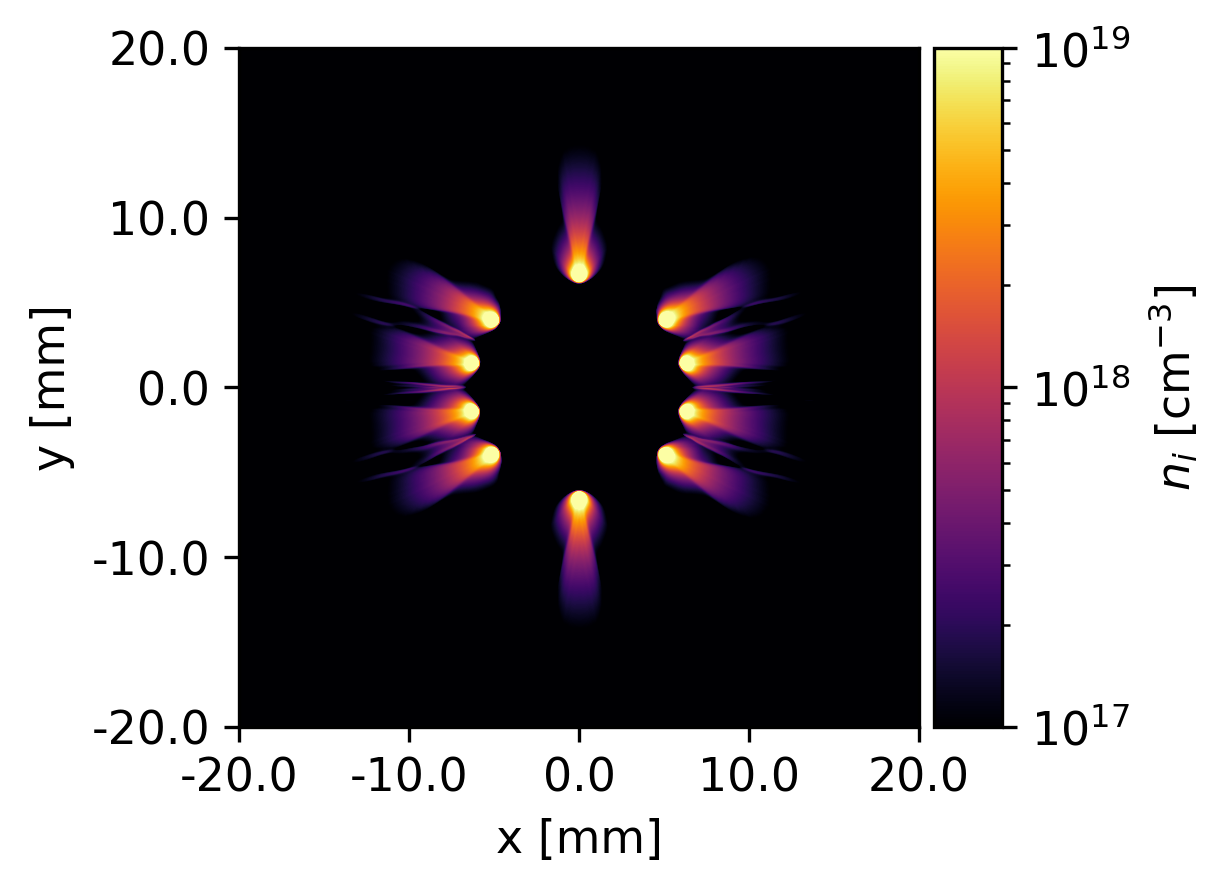

In [5]:
# Show full ni map
arrName = 'rho_Al'
#tid = 200

plt.rcParams.update({'font.size': 11})
fig,axs = plt.subplots(1, 1,figsize=(6.5,3), dpi=300)

out, spacing = loadMap(inDir,tid,arrName)
out = out / mi # ni [per m cubed]
# Plot
cbar,im = showMap(axs,out[:,:,210].T/1e6,np.array([-20,20]),np.array([-20,20]),10,10,spacing,np.array([1e17,1e19]),'inferno')
cbar.set_label("$n_i$ [cm$^{-3}$]") # label colorbar
# axs.set_title(arrName + ' t = ' +str(tid) + ' ns', fontsize=4)

#axs.set_xticklabels(np.arange(-80,81,step=20))
#axs.set_yticklabels(np.arange(-40,41,step=20))

fig = plt.gcf()
plt.show()
#fig.savefig( savePath + arrName + '-full.png', bbox_inches='tight')

# Get electron density

(800, 800, 420)
(800, 800, 420)
(800, 800, 420)


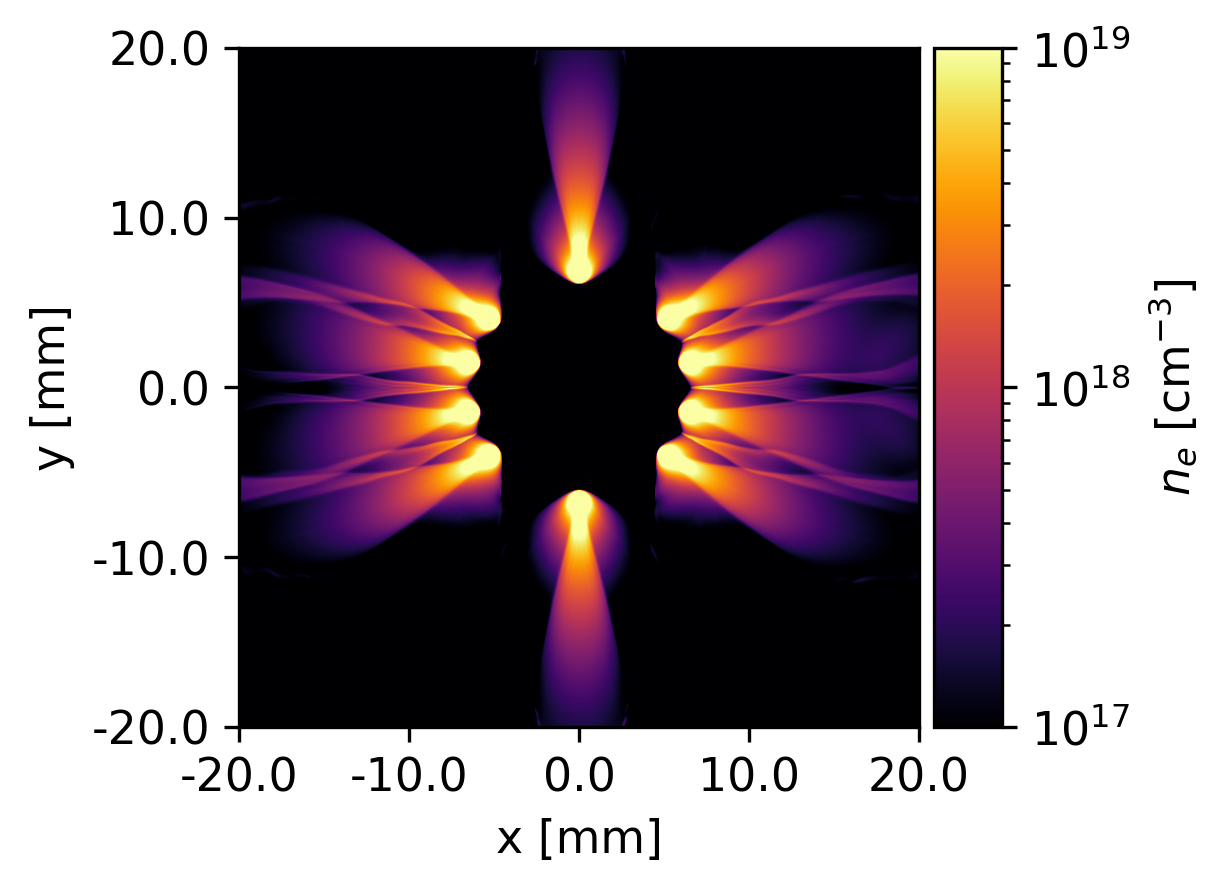

In [6]:
# Show full ne map
arrName = 'rho_Al'
#tid = 250

plt.rcParams.update({'font.size': 11})
fig,axs = plt.subplots(1, 1,figsize=(6.5,3), dpi=300)

rho, spacing = loadMap(inDir,tid,'rho_Al') # kg/m^3
rho = rho * 1e3 * 1e-6 # g/cm^-3
Te, spacing = loadMap(inDir,tid,'Te') # eV

Zbar, ne = getZbarTF(z=13, a=27, rho=rho, tev=Te) # Get Zbar and ne using Thomas Fermi Model, ne in cm^-3
print(ne.shape)


# Plot
cbar,im = showMap(axs,ne[:,:,210].T,np.array([-20,20]),np.array([-20,20]),10,10,spacing,np.array([1e17,1e19]),'inferno')
cbar.set_label("$n_e$ [cm$^{-3}$]") # label colorbar
# axs.set_title(arrName + ' t = ' +str(tid) + ' ns', fontsize=4)

#axs.set_xticklabels(np.arange(-80,81,step=20))
#axs.set_yticklabels(np.arange(-40,41,step=20))

fig = plt.gcf()
plt.show()


(800, 800, 420)
(800, 800, 420)
(800, 800, 420)


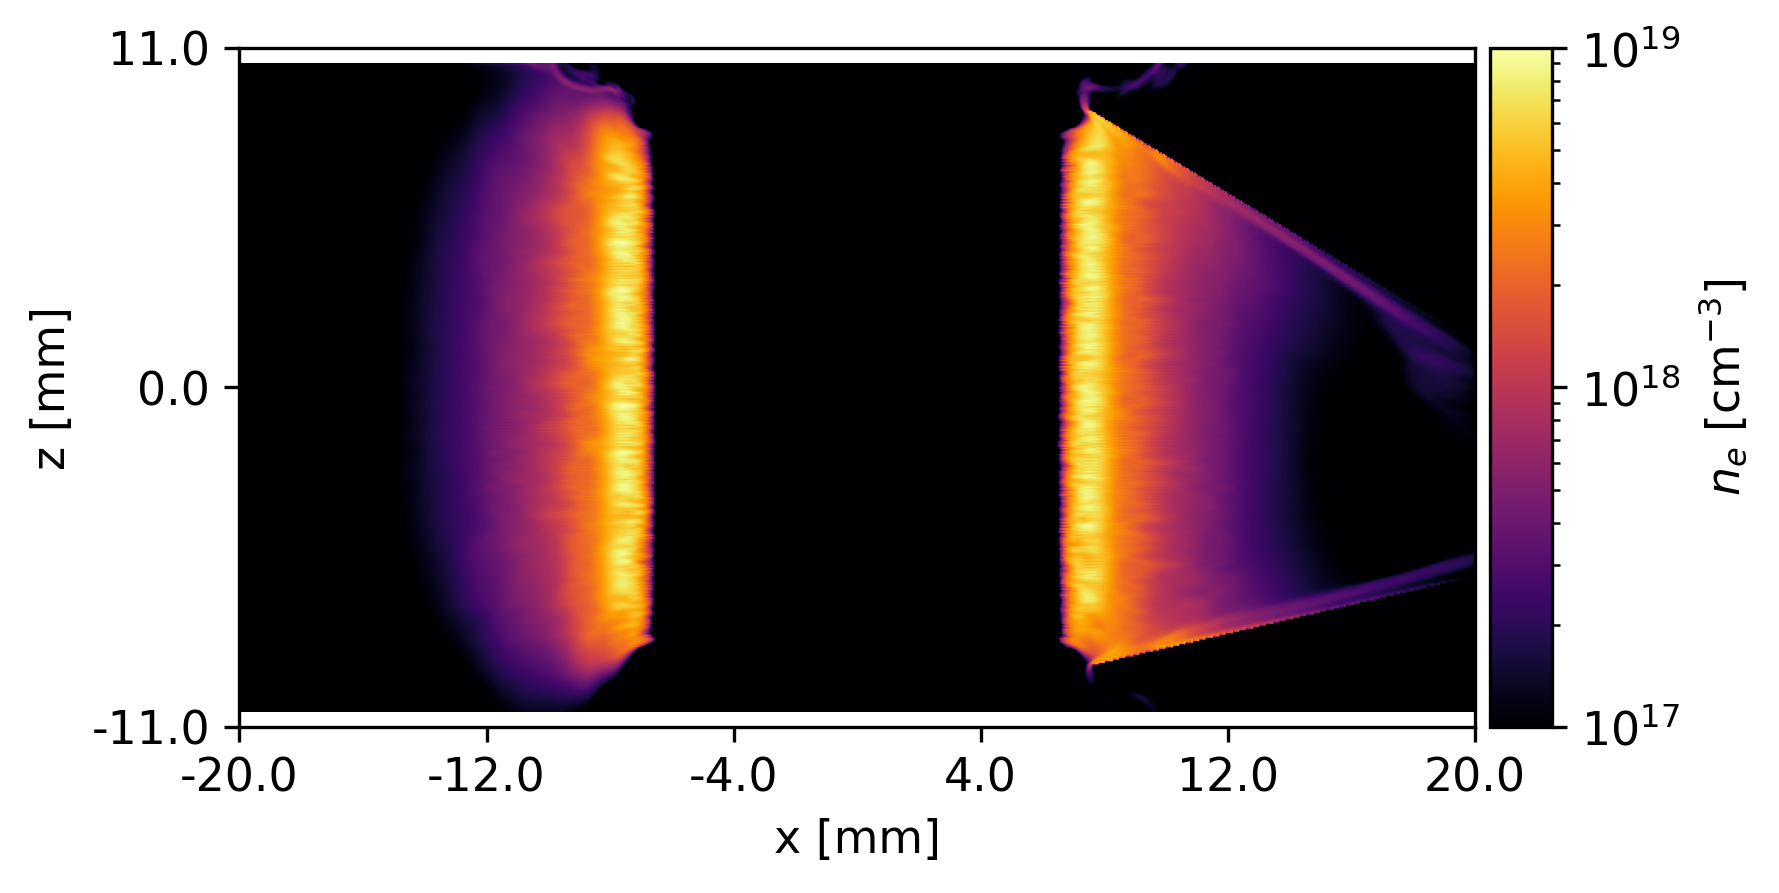

In [7]:
# 
plt.rcParams.update({'font.size': 11})
fig,axs = plt.subplots(1, 1,figsize=(6.5,3), dpi=300)

rho, spacing = loadMap(inDir,tid,'rho_Al') # kg/m^3
rho = rho * 1e3 * 1e-6 # g/cm^-3
Te, spacing = loadMap(inDir,tid,'Te') # eV

Zbar, ne = getZbarTF(z=13, a=27, rho=rho, tev=Te) # Get Zbar and ne using Thomas Fermi Model, ne in cm^-3
print(ne.shape)  # (800, 800, 420) = (x, y, z)

# 
ax,data,xlms,ylms,xstp_mm,ystp_mm,spacing,caxlim,clrmap = axs,ne[:,400,:].T,np.array([-20,20]),np.array([-11,11]),8,11,spacing,np.array([1e17,1e19]),'inferno'
# 
out = data
#ax = plt.gca()
ax.set_xlabel('x [mm]')
ax.set_ylabel('z [mm]')
im = ax.imshow(out,norm=LogNorm(vmin=caxlim[0], vmax=caxlim[1]),cmap=clrmap) # Plot image
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
# 
cbar = plt.colorbar(im,cax=cax)
#im.set_clim(caxlim[0],caxlim[1]) 
ax.invert_yaxis()
#cbar.set_label("$n_e$ [x $10^{18}$ cm$^{-3}$]")
# 
# set limits
xstp = round(xstp_mm / (spacing[0]*1e3))
ystp = round(ystp_mm / (spacing[0]*1e3))
ax.set_xlim([xlms[0] * 1/(spacing[0]*1e3) + out.shape[1]/2, xlms[1] * 1/(spacing[0]*1e3) + out.shape[1]/2] )
ax.set_ylim([ylms[0]  * 1/(spacing[0]*1e3) + out.shape[0]/2, ylms[1] * 1/(spacing[0]*1e3) + out.shape[0]/2] )
# 
# Set axis labels
# 
ax.set_xticks(np.round(np.arange(xlms[0]*1/(spacing[0]*1e3),xlms[1]*1/(spacing[0]*1e3),step=xstp) + out.shape[1]/2))
ax.set_yticks(np.round(np.arange(ylms[0]*1/(spacing[0]*1e3),ylms[1]*1/(spacing[0]*1e3),step=ystp) + out.shape[0]/2))
# 
labels_xmm = np.round((ax.get_xticks()-out.shape[1]/2) * spacing[0] *1e3)
labels_ymm = np.round((ax.get_yticks()-out.shape[0]/2) * spacing[0] *1e3)
ax.set_xticklabels(labels_xmm)
ax.set_yticklabels(labels_ymm)
# 
cbar.set_label("$n_e$ [cm$^{-3}$]") # label colorbar
# axs.set_title(arrName + ' t = ' +str(tid) + ' ns', fontsize=4)

#axs.set_xticklabels(np.arange(-80,81,step=20))
#axs.set_yticklabels(np.arange(-40,41,step=20))

fig = plt.gcf()
plt.show()


## save ne in m^-3

In [8]:
# 
np.save(f'{save_dir}{save_name}', ne * cm3_per_m3)  # m^-3, save 2D e- density mesh
